In [29]:
import itertools
import os
import random

import cv2  # poetry add opencv-python
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import mish, relu, sigmoid, softmax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import fashion_mnist
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import losses
from keras import metrics
from keras import optimizers


###### __freeze random state__ (initialize the random number generator)

- https://www.w3schools.com/python/ref_random_seed.asp

In [30]:
print(random.random())
print(random.random())
random.seed(42)
print(a:=random.random())
print(random.random())
random.seed(42)
print(b:=random.random())
assert a == b, 'Something wrong!'

0.1626540971560848
0.3552707002275215
0.6394267984578837
0.025010755222666936
0.6394267984578837


In [31]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    

set_seed(42)  # 42 from The Hitchhiker's Guide to the Galaxy ^_^

### __Dataset__

###### __fashion_mnist__

In [32]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train.dtype, x_train[0].shape

(dtype('uint8'), (28, 28))

In [33]:
NUM_FEATURES = x_train[0].shape[0] * x_train[0].shape[1]

In [34]:
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# each sample (28x28) to 1x784
x_train, x_test = x_train.reshape([-1, NUM_FEATURES]), x_test.reshape([-1, NUM_FEATURES])
print(min(x_train.min(), x_test.min()))
maximum = max(x_train.max(), x_test.max()) # np.max([x_train.max(), x_test.max()]) 
maximum

0.0


255.0

In [35]:
# Normalize (min = 0)
x_train, x_test = x_train / maximum, x_test / maximum

In [36]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [37]:
max(y_train.max(), y_test.max()), min(y_train.min(), y_test.min())

(9, 0)

In [38]:
NUM_CLASSES = len(set(np.concatenate((y_train, y_test), axis=0)))
NUM_CLASSES

10

In [39]:
y_true = tf.one_hot(y_train, depth=NUM_CLASSES).numpy()
y_truev = tf.one_hot(y_test, depth=NUM_CLASSES).numpy()
y_true.shape, y_truev.shape

((60000, 10), (10000, 10))

###### __cifar10__

- https://www.tensorflow.org/datasets/catalog/cifar10
- https://www.cs.toronto.edu/~kriz/cifar.html
- https://github.com/YoongiKim/CIFAR-10-images

In [40]:
# needed:
# (x_train, y_train), (x_test, y_test) = dataset
# NUM_FEATURES
# NUM_CLASSES

In [41]:
# PATH_IMGS = '/home/denys/Desktop/PythonDataScience/datas/Hw_9/CIFAR-10-images-master/'
PATH_IMGS = os.path.join(os.getcwd(), 'CIFAR-10-images-master', 'train')

ids = []  # full image paths
labels = []  # true mark 'images name-description' by label2index:
# label2index = {kind:num for num, kind in enumerate(os.listdir(PATH_IMGS))}
label2index = {}

for num, folder in enumerate(os.listdir(PATH_IMGS)):
    label2index[folder] = num
    for image_name in os.listdir(os.path.join(PATH_IMGS, folder))[:500]:  # limit 500 for each - for example
        ids.append(os.path.join(PATH_IMGS, folder, image_name))
        labels.append(label2index[folder])

NUM_CLASSES = num + 1
NUM_CLASSES

10

In [42]:
label2index

{'dog': 0,
 'ship': 1,
 'frog': 2,
 'automobile': 3,
 'bird': 4,
 'deer': 5,
 'truck': 6,
 'cat': 7,
 'airplane': 8,
 'horse': 9}

In [43]:
index2label = {y: x for x, y in label2index.items()}
index2label

{0: 'dog',
 1: 'ship',
 2: 'frog',
 3: 'automobile',
 4: 'bird',
 5: 'deer',
 6: 'truck',
 7: 'cat',
 8: 'airplane',
 9: 'horse'}

In [44]:
ids_train, ids_valid, y_train, y_valid = train_test_split(ids, labels, test_size=0.2, shuffle=True)

- https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
- https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html
- https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

- https://docs.opencv.org/3.4/d4/da8/group__imgcodecs.html
- https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/

In [45]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, ids: list, y: list, shuffle: bool=True, batch_size: int=256) -> None:
        self.ids = ids  # list of imgs path
        self.y = y
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.ids))
        self.batch_size = batch_size
        self.num_features = self.num_features if self.__getitem__(0) else 0
        
        if shuffle:
            self.on_epoch_end()
    
    def __len__(self) -> int:
        return len(self.ids) // self.batch_size
    
    def __getitem__(self, idx: int) -> tuple:  # get one batch
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_ids = [self.ids[i] for i in indexes]
        batch_y = [tf.keras.utils.to_categorical(self.y[i], 10) for i in indexes]
        
        batch_X = []
        for i in range(self.batch_size):
            img = cv2.imread(batch_ids[i])  # i/o disk operation! but low RAM uses
            img = np.mean(img, axis=-1)  # RGB to grayscale

            batch_X.append(img.reshape(len(img[0]) * len(img)))  # into a one-dimensional vector
        
        self.num_features = len(img[0]) * len(img) # !!
        
        return np.array(batch_X), np.array(batch_y)
        
    def on_epoch_end(self) -> None:
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [46]:
# train_dataset = Dataset(ids_train, y_train, shuffle=True, batch_size=256)
# X, y = train_dataset[0]
# X.shape, y.shape

In [47]:
# for i in range(4):
#     plt.figure(figsize=(2, 2))
#     # plt.title(index2label[y[i]])
#     plt.imshow(X[i].reshape(32, 32))
#     plt.show()

In [48]:
train_dataset = Dataset(ids_train, y_train, shuffle=True, batch_size=256)
# train_dataset[0]
NUM_FEATURES = train_dataset.num_features
valid_dataset = Dataset(ids_valid, y_valid, shuffle=False, batch_size=256)
NUM_FEATURES

1024

### __Model__

- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
- https://keras.io/api/layers/regularization_layers/dropout/

In [49]:
def create_NN(n_hidden_: list, activation: list, optimizer=optimizers.SGD, learning_rate=0.1) -> Sequential:
    model = Sequential(name=f'''m-{''.join(map(str, [f'{i}-' for i in n_hidden_[1:-1]]))}{''.join(map(str, [f'{a}-' for a in activation[:-1]]))}{optimizer.__name__}-{learning_rate}''')
    n_layers = len(n_hidden_)
    for layer in range(1, n_layers):
        model.add(Dense(n_hidden_[layer], activation=activation[layer-1], input_shape=(n_hidden_[layer-1],)))
        # model.add(Dropout(.5)) if layer + 1 != n_layers else None # 0.5 Fraction of the input units to drop.

    model.compile(
                  optimizer=optimizer(learning_rate=learning_rate), # legacy
                  loss=losses.CategoricalCrossentropy(),  # 'categorical_crossentropy' losses.binary_crossentropy,
                  metrics=['accuracy', metrics.CategoricalAccuracy()]  # metrics.BinaryAccuracy()  metrics.CategoricalAccuracy()  or metrics.Accuracy()?
                  )

    return model

### __Training__

In [50]:
def draw_2twin_2d(y00: np.array, y01: np.array, y10: np.array, y11: np.array, suptitle: str) -> None:
    x = range(1, len(y00) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 8))

    axs[0].plot(x, y00, 'bo', label='Training loss')
    axs[0].plot(x, y01, 'g', label='Validation loss')
    axs[0].title.set_text('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(x, y10, 'bo', label='Training acc')
    axs[1].plot(x, y11, 'g', label='Validation acc')
    axs[1].title.set_text('Training and validation acc')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Acc')
    axs[1].legend()
    axs[1].grid()
    
    fig.suptitle(suptitle)
    # plt.legend()
    # plt.grid()
    plt.show()

In [51]:
# print(history[0].history.keys())
""" 
loss - список, в якому зберігається історія змін помилки на навчальних даних залежно від епохи
val_loss - список, де зберігається історія змін помилки на тестових даних залежно від епохи
accuracy - список, в якому зберігається історія змін точності на навчальних даних залежно від епохи
val_accuracy - список, де зберігається історія змін точності на тестових даних залежно від епохи
"""

' \nloss - список, в якому зберігається історія змін помилки на навчальних даних залежно від епохи\nval_loss - список, де зберігається історія змін помилки на тестових даних залежно від епохи\naccuracy - список, в якому зберігається історія змін точності на навчальних даних залежно від епохи\nval_accuracy - список, де зберігається історія змін точності на тестових даних залежно від епохи\n'

- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [52]:
callback_early_stopping = EarlyStopping(
                                        monitor='val_categorical_accuracy',  # val_loss
                                        patience=4,
                                        )

callback_save = ModelCheckpoint(
                                'best.hdf5',  # name to save the resulting model
                                monitor='val_loss',
                                save_best_only=True,
                                )

In [53]:
def test_NN(
            train_dataset: Dataset, 
            valid_dataset: Dataset, 
            set_layers: list, 
            act: list, 
            opt: optimizers, 
            lr: float,  
            epochs: int=100
            ) -> None:
    """For test one model."""
    model = create_NN(
                      n_hidden_=set_layers, 
                      activation=act, 
                      optimizer=opt, 
                      learning_rate=lr
                      )

    history = model.fit(
                        train_dataset,
                        validation_data=valid_dataset,
                        epochs=epochs,
                        verbose=1, # print logs
                        callbacks=[callback_early_stopping]  # callback_save
                        )

    loss_values = history.history['loss']
    val_loss_values = history.history['val_loss']
    acc_values = history.history['categorical_accuracy']
    val_acc_values = history.history['val_categorical_accuracy']   

    draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=f'{model.name}({train_dataset.batch_size})')

In [54]:
train_dataset.batch_size

256

Epoch 1/100


15/15 [==============================] - 1s 46ms/step - loss: 288.4557 - accuracy: 0.0990 - categorical_accuracy: 0.0990 - val_loss: 65.3191 - val_accuracy: 0.1094 - val_categorical_accuracy: 0.1094
Epoch 2/100
15/15 [==============================] - 1s 34ms/step - loss: 48.7537 - accuracy: 0.1214 - categorical_accuracy: 0.1214 - val_loss: 26.2903 - val_accuracy: 0.1185 - val_categorical_accuracy: 0.1185
Epoch 3/100
15/15 [==============================] - 1s 35ms/step - loss: 19.6603 - accuracy: 0.1320 - categorical_accuracy: 0.1320 - val_loss: 13.9475 - val_accuracy: 0.1471 - val_categorical_accuracy: 0.1471
Epoch 4/100
15/15 [==============================] - 1s 34ms/step - loss: 12.9909 - accuracy: 0.1333 - categorical_accuracy: 0.1333 - val_loss: 11.1494 - val_accuracy: 0.1328 - val_categorical_accuracy: 0.1328
Epoch 5/100
15/15 [==============================] - 1s 34ms/step - loss: 9.9295 - accuracy: 0.1445 - categorical_accuracy: 0.1445 - val_loss: 9.5264 - val_accuracy: 0.132

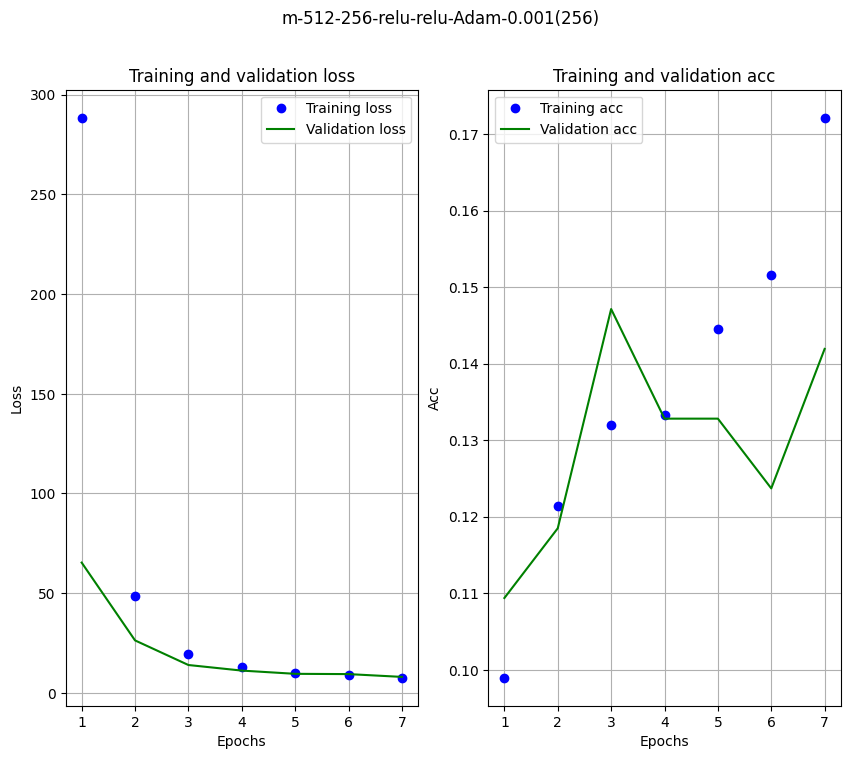

In [55]:
test_NN(
        train_dataset=train_dataset,
        valid_dataset=valid_dataset,
        set_layers=[NUM_FEATURES, 512, 256, NUM_CLASSES], 
        act=['relu', 'relu', 'softmax'], 
        opt=optimizers.legacy.Adam, 
        lr=0.001,
        epochs=100
        )

__!!!+ test dataset + draw results?__